# Лабораторная работа №3: Решающее дерево (Decision Tree)
### Классификация: Обнаружение мошеннических транзакций (Decision Tree Classifier)
### Регрессия: Предсказание суммы транзакции (Decision Tree Regressor)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, mean_squared_error, 
                             mean_absolute_error, r2_score)
import optuna
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Загрузка данных
df = pd.read_csv('../dataset/fraud-detection/fraud.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())

Размер датасета: (81042, 23)

Первые 5 строк:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0      885451   2019-12-23 04:21:22  6506116513503136   
1      957791   2020-01-20 02:30:18  3523843138706408   
2      134374   2019-03-15 05:42:43   346273234529002   
3      529890   2019-08-16 14:02:32  2712209726293386   
4      772865   2019-11-26 21:22:21  3598215285024754   

                              merchant       category    amt     first  \
0            fraud_Ledner-Pfannerstill  gas_transport  97.75  Kimberly   
1  fraud_Eichmann, Bogan and Rodriguez  gas_transport  73.34     Grace   
2                fraud_Halvorson Group       misc_pos   6.09     Donna   
3                    fraud_Yost-Rogahn  personal_care  36.70     Jenna   
4       fraud_Hoppe, Harris and Bednar  entertainment  66.30    Ashley   

       last gender                        street  ...      lat     long  \
0      Rice      F    63991 Destiny Rue Apt. 651  ...  32.2768 -95.3031   
1  Williams     

## 1. ВЫБОР НАЧАЛЬНЫХ УСЛОВИЙ И ОБОСНОВАНИЕ

### 1a. Задача классификации: Обнаружение мошеннических транзакций
**Модель:** Decision Tree Classifier

**Обоснование:** Решающие деревья - мощный непараметрический алгоритм, способный моделировать нелинейные зависимости. Идеально подходят для обнаружения мошенничества благодаря:
- Интерпретируемости: можно визуализировать правила принятия решений
- Способности работать с нелинейными закономерностями
- Не требуют нормализации данных (хотя мы применим для сравнимости с другими алгоритмами)
- Автоматически выявляют важные признаки

### 1b. Задача регрессии: Предсказание суммы транзакции
**Модель:** Decision Tree Regressor

**Обоснование:** Decision Tree Regressor подходит для предсказания суммы транзакции, так как:
- Может моделировать сложные нелинейные зависимости между признаками
- Устойчив к выбросам
- Позволяет понять, какие факторы влияют на сумму транзакции

### 1c. Выбор метрик качества

**Для классификации:**
- **F1-Score** (основная): баланс между precision и recall при несбалансированных классах
- **ROC-AUC**: общая способность различать классы
- **Accuracy, Precision, Recall**: дополнительные метрики

**Для регрессии:**
- **R² Score** (основная): доля объясненной дисперсии
- **MAE**: средняя абсолютная ошибка (интерпретируемость)
- **MSE**: штраф за большие ошибки

In [2]:
# Анализ целевых переменных
print("Распределение целевых переменных:")
print("\nКлассификация (is_fraud):")
print(df['is_fraud'].value_counts())
print(f"Доля мошеннических операций: {df['is_fraud'].mean():.4f}")

print("\nРегрессия (amt):")
print(f"Минимальная сумма: {df['amt'].min():.2f}")
print(f"Максимальная сумма: {df['amt'].max():.2f}")
print(f"Средняя сумма: {df['amt'].mean():.2f}")

Распределение целевых переменных:

Классификация (is_fraud):
is_fraud
0    80571
1      471
Name: count, dtype: int64
Доля мошеннических операций: 0.0058

Регрессия (amt):
Минимальная сумма: 1.00
Максимальная сумма: 27119.77
Средняя сумма: 70.74


## 2. СОЗДАНИЕ БЕЙЗЛАЙНА И ОЦЕНКА КАЧЕСТВА

### Важно: Базовая модель использует ТОЛЬКО исходные числовые признаки БЕЗ feature engineering

In [3]:
# Базовые числовые признаки (как в lab1 и lab2)
numeric_features = ['lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']

X_base = df[numeric_features].copy()
y_class_base = df['is_fraud']
y_reg_base = df['amt']

# Разделение на train/test
X_train_base, X_test_base, y_class_train_base, y_class_test_base = train_test_split(
    X_base, y_class_base, test_size=0.3, random_state=42, stratify=y_class_base
)

X_train_reg_base, X_test_reg_base, y_reg_train_base, y_reg_test_base = train_test_split(
    X_base, y_reg_base, test_size=0.3, random_state=42
)

print(f"Размер обучающей выборки: {X_train_base.shape}")
print(f"Размер тестовой выборки: {X_test_base.shape}")
print(f"Количество признаков: {len(numeric_features)}")

Размер обучающей выборки: (56729, 6)
Размер тестовой выборки: (24313, 6)
Количество признаков: 6


### 2a. Обучение базовых моделей

In [4]:
# Масштабирование признаков (для единообразия с другими лабораторными)
scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base)
X_test_base_scaled = scaler_base.transform(X_test_base)

X_train_reg_base_scaled = scaler_base.fit_transform(X_train_reg_base)
X_test_reg_base_scaled = scaler_base.transform(X_test_reg_base)

# Базовые модели с дефолтными параметрами
tree_class_base = DecisionTreeClassifier(random_state=42)
tree_reg_base = DecisionTreeRegressor(random_state=42)

# Обучение
print("Обучение базовых моделей...")
tree_class_base.fit(X_train_base_scaled, y_class_train_base)
tree_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base)

# Предсказания
y_class_pred_base = tree_class_base.predict(X_test_base_scaled)
y_class_proba_base = tree_class_base.predict_proba(X_test_base_scaled)[:, 1]
y_reg_pred_base = tree_reg_base.predict(X_test_reg_base_scaled)

print("Базовые модели обучены")

Обучение базовых моделей...
Базовые модели обучены


### 2b. Оценка качества базовых моделей

In [5]:
print("=== РЕЗУЛЬТАТЫ БАЗОВОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Базовая Decision Tree):") 
print(f"Accuracy:  {accuracy_score(y_class_test_base, y_class_pred_base):.4f}")
print(f"Precision: {precision_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_base, y_class_pred_base, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_base, y_class_proba_base):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_class_test_base, y_class_pred_base))

print("\nРЕГРЕССИЯ (Базовая Decision Tree):")
print(f"MAE: {mean_absolute_error(y_reg_test_base, y_reg_pred_base):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_base, y_reg_pred_base):.4f}")
print(f"R²:  {r2_score(y_reg_test_base, y_reg_pred_base):.4f}")

# Сохраняем базовые результаты для сравнения
baseline_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_base, y_class_pred_base),
        'f1': f1_score(y_class_test_base, y_class_pred_base, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_base, y_class_proba_base)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_base, y_reg_pred_base),
        'r2': r2_score(y_reg_test_base, y_reg_pred_base)
    }
}

=== РЕЗУЛЬТАТЫ БАЗОВОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Базовая Decision Tree):
Accuracy:  0.9893
Precision: 0.0952
Recall:    0.0993
F1-Score:  0.0972
ROC-AUC:   0.5469

Матрица ошибок:
[[24039   133]
 [  127    14]]

РЕГРЕССИЯ (Базовая Decision Tree):
MAE: 84.2398
MSE: 71769.3315
R²:  -2.9538


## 3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА

### 3a. Формулировка гипотез:
1. **Feature Engineering**: Создание новых признаков улучшит качество
   - Временные признаки (час, день недели, выходные)
   - Географические признаки (расстояние между точками)
   - Возраст клиента
   - Полиномиальные взаимодействия признаков

2. **Отбор признаков**: Удаление нерелевантных признаков через feature importance деревьев

3. **Подбор гиперпараметров**: Настройка глубины дерева, минимального размера листьев и узлов через Optuna

4. **Обработка категориальных признаков**: OneHot encoding для категорий

### 3b. Проверка гипотез: Feature Engineering

In [6]:
# ВЕКТОРИЗОВАННАЯ функция haversine 
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Векторизованное вычисление расстояния по формуле гаверсинуса
    """
    # Конвертируем в радианы
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Формула гаверсинуса
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return 6371 * c  # Радиус Земли в км


# Создаем копию
df_improved = df.copy()

print("Начинаем feature engineering...")

# 1. Временные признаки 
print("  1/7 Временные признаки...")
df_improved['trans_date_trans_time'] = pd.to_datetime(df_improved['trans_date_trans_time'])
df_improved['hour'] = df_improved['trans_date_trans_time'].dt.hour
df_improved['day_of_week'] = df_improved['trans_date_trans_time'].dt.dayofweek
df_improved['month'] = df_improved['trans_date_trans_time'].dt.month
df_improved['is_weekend'] = (df_improved['day_of_week'] >= 5).astype(np.int8)  
df_improved['is_night'] = ((df_improved['hour'] >= 22) | (df_improved['hour'] <= 6)).astype(np.int8)

# 2. Географические признаки 
print("  2/7 Географические признаки (векторизовано)...")
df_improved['distance_km'] = haversine_vectorized(
    df_improved['lat'].values,
    df_improved['long'].values,
    df_improved['merch_lat'].values,
    df_improved['merch_long'].values
)

# 3. Возраст 
print("  3/7 Возраст...")
df_improved['dob'] = pd.to_datetime(df_improved['dob'])
df_improved['age'] = (df_improved['trans_date_trans_time'] - df_improved['dob']).dt.days // 365

# 4. OneHot encoding для категориальных признаков
print("  4/7 OneHot encoding категорий...")
categorical_features = ['category', 'gender', 'state', 'job']

# Для каждого категориального признака создаем OneHot
for cat_feat in categorical_features:
    if cat_feat in df_improved.columns:
        # Берем топ категорий (чтобы не создать слишком много признаков)
        top_categories = df_improved[cat_feat].value_counts().head(10).index
        for category in top_categories:
            df_improved[f'{cat_feat}_{category}'] = (df_improved[cat_feat] == category).astype(np.int8)

# 5. Полиномиальные признаки (перемножение числовых признаков)
print("  5/7 Полиномиальные взаимодействия...")
num_features_for_poly = ['lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age', 'distance_km']

# Создаем парные взаимодействия для важных признаков
df_improved['lat_long'] = df_improved['lat'] * df_improved['long']
df_improved['merch_lat_long'] = df_improved['merch_lat'] * df_improved['merch_long']
df_improved['distance_age'] = df_improved['distance_km'] * df_improved['age']
df_improved['city_pop_distance'] = df_improved['city_pop'] * df_improved['distance_km']

# 6. Отбираем только числовые признаки
print("  6/7 Отбор числовых признаков...")
feature_columns = df_improved.select_dtypes(include=[np.number]).columns.tolist()
feature_columns = [col for col in feature_columns if col not in ['is_fraud', 'amt', 'Unnamed: 0']]

# 7. Разделение данных
print("  7/7 Разделение на train/test...")
X_imp = df_improved[feature_columns].copy()
y_class_imp = df_improved['is_fraud']
y_reg_imp = df_improved['amt']

X_train_imp, X_test_imp, y_class_train_imp, y_class_test_imp = train_test_split(
    X_imp, y_class_imp, test_size=0.3, random_state=42, stratify=y_class_imp
)

X_train_reg_imp, X_test_reg_imp, y_reg_train_imp, y_reg_test_imp = train_test_split(
    X_imp, y_reg_imp, test_size=0.3, random_state=42
)

print(f"\nГотово! Создано {len(feature_columns)} признаков")
print(f"Размер обучающей выборки: {X_train_imp.shape}")

Начинаем feature engineering...
  1/7 Временные признаки...
  2/7 Географические признаки (векторизовано)...
  3/7 Возраст...
  4/7 OneHot encoding категорий...
  5/7 Полиномиальные взаимодействия...
  6/7 Отбор числовых признаков...
  7/7 Разделение на train/test...

Готово! Создано 51 признаков
Размер обучающей выборки: (56729, 51)


### Анализ корреляции признаков

Топ-15 признаков по корреляции с is_fraud:
is_night                   0.085978
category_shopping_net      0.044091
category_grocery_pos       0.041656
category_home              0.017485
category_health_fitness    0.017112
category_kids_pets         0.016222
category_food_dining       0.016179
category_personal_care     0.015729
gender_F                   0.013734
gender_M                   0.013734
age                        0.012887
hour                       0.012815
month                      0.011701
unix_time                  0.009852
category_entertainment     0.009027
dtype: float64

Топ-15 признаков по корреляции с amt:
category_grocery_pos       0.072464
category_shopping_net      0.032724
category_personal_care     0.032377
category_food_dining       0.027080
is_night                   0.023784
category_health_fitness    0.023074
category_home              0.021831
category_kids_pets         0.019558
category_shopping_pos      0.015257
hour                       0.013700
cat

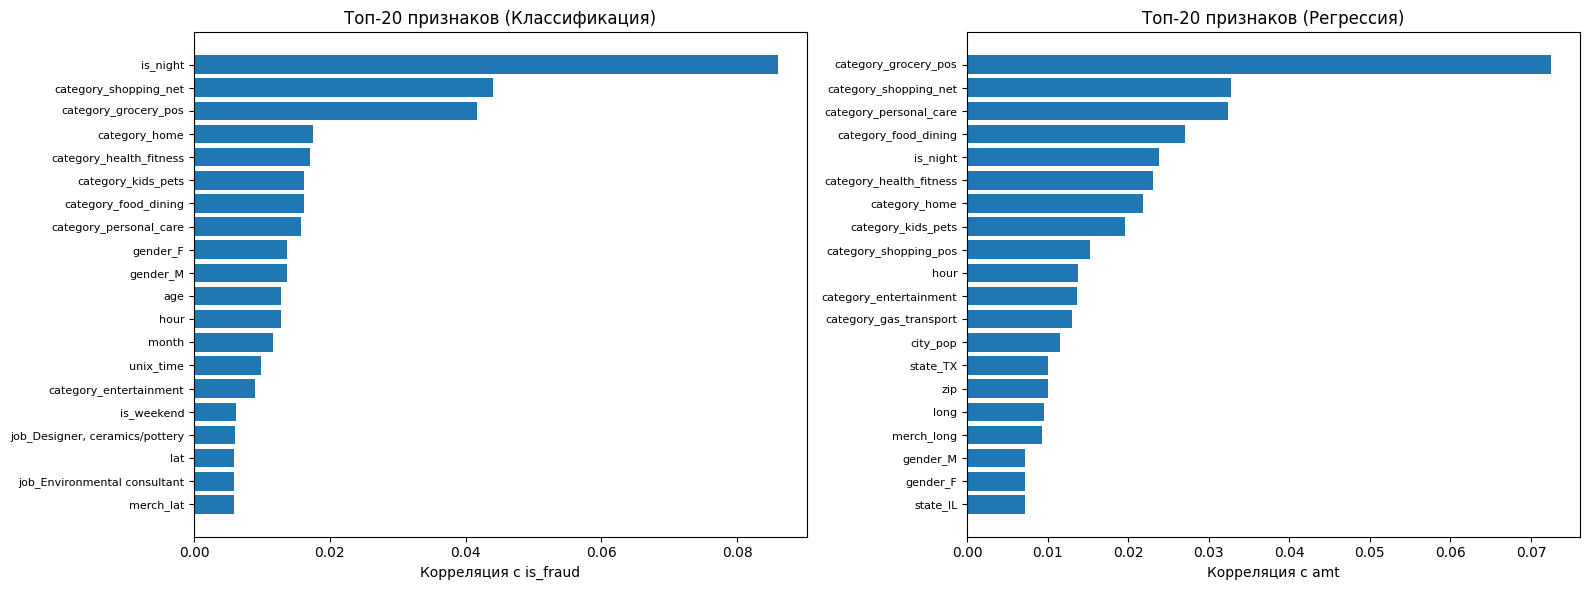

In [7]:
# Вычисляем корреляцию признаков с целевыми переменными
correlation_with_fraud = X_train_imp.corrwith(y_class_train_imp).abs().sort_values(ascending=False)
correlation_with_amt = X_train_imp.corrwith(y_reg_train_imp).abs().sort_values(ascending=False)

print("Топ-15 признаков по корреляции с is_fraud:")
print(correlation_with_fraud.head(15))

print("\nТоп-15 признаков по корреляции с amt:")
print(correlation_with_amt.head(15))

# Визуализация корреляции топ признаков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Топ-20 признаков для классификации
top_features_class_corr = correlation_with_fraud.head(20)
axes[0].barh(range(len(top_features_class_corr)), top_features_class_corr.values)
axes[0].set_yticks(range(len(top_features_class_corr)))
axes[0].set_yticklabels(top_features_class_corr.index, fontsize=8)
axes[0].set_xlabel('Корреляция с is_fraud')
axes[0].set_title('Топ-20 признаков (Классификация)')
axes[0].invert_yaxis()

# Топ-20 признаков для регрессии
top_features_reg_corr = correlation_with_amt.head(20)
axes[1].barh(range(len(top_features_reg_corr)), top_features_reg_corr.values)
axes[1].set_yticks(range(len(top_features_reg_corr)))
axes[1].set_yticklabels(top_features_reg_corr.index, fontsize=8)
axes[1].set_xlabel('Корреляция с amt')
axes[1].set_title('Топ-20 признаков (Регрессия)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 3c. Отбор важных признаков через Feature Importance

Анализ важности признаков через Decision Tree...

Топ-20 важных признаков для классификации:
age                       0.250344
category_shopping_pos     0.107502
unix_time                 0.073900
city_pop                  0.054050
hour                      0.041495
merch_lat_long            0.039932
category_shopping_net     0.039652
month                     0.037905
category_grocery_pos      0.035587
city_pop_distance         0.034637
distance_km               0.034043
merch_lat                 0.032468
zip                       0.030739
merch_long                0.029082
gender_M                  0.027194
distance_age              0.024599
day_of_week               0.021131
long                      0.014567
category_entertainment    0.014444
cc_num                    0.012907
dtype: float64

Топ-20 важных признаков для регрессии:
unix_time                0.655436
distance_km              0.166280
distance_age             0.036837
age                      0.026736
merch_lat       

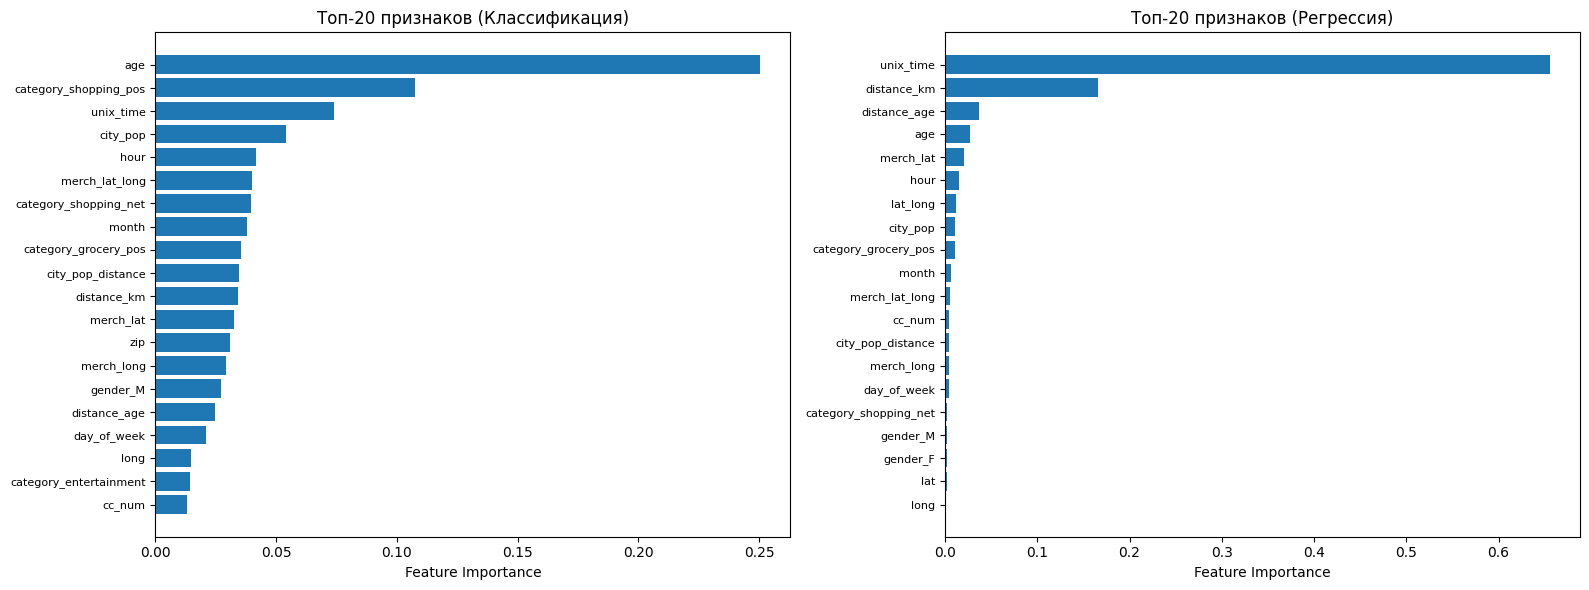

In [8]:
# Обучим временные деревья для получения feature importance
print("Анализ важности признаков через Decision Tree...")

# Масштабирование (для единообразия)
scaler_imp = StandardScaler()
X_train_imp_scaled = scaler_imp.fit_transform(X_train_imp)
X_test_imp_scaled = scaler_imp.transform(X_test_imp)

X_train_reg_imp_scaled = scaler_imp.fit_transform(X_train_reg_imp)
X_test_reg_imp_scaled = scaler_imp.transform(X_test_reg_imp)

# Обучаем деревья для feature importance
temp_tree_class = DecisionTreeClassifier(max_depth=10, random_state=42)
temp_tree_class.fit(X_train_imp_scaled, y_class_train_imp)

temp_tree_reg = DecisionTreeRegressor(max_depth=10, random_state=42)
temp_tree_reg.fit(X_train_reg_imp_scaled, y_reg_train_imp)

# Получаем важность признаков
feature_importance_class = pd.Series(
    temp_tree_class.feature_importances_, 
    index=X_train_imp.columns
).sort_values(ascending=False)

feature_importance_reg = pd.Series(
    temp_tree_reg.feature_importances_, 
    index=X_train_reg_imp.columns
).sort_values(ascending=False)

print("\nТоп-20 важных признаков для классификации:")
print(feature_importance_class.head(20))

print("\nТоп-20 важных признаков для регрессии:")
print(feature_importance_reg.head(20))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Классификация
top_20_class = feature_importance_class.head(20)
axes[0].barh(range(len(top_20_class)), top_20_class.values)
axes[0].set_yticks(range(len(top_20_class)))
axes[0].set_yticklabels(top_20_class.index, fontsize=8)
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Топ-20 признаков (Классификация)')
axes[0].invert_yaxis()

# Регрессия
top_20_reg = feature_importance_reg.head(20)
axes[1].barh(range(len(top_20_reg)), top_20_reg.values)
axes[1].set_yticks(range(len(top_20_reg)))
axes[1].set_yticklabels(top_20_reg.index, fontsize=8)
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Топ-20 признаков (Регрессия)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [9]:
# Отбираем топ-30 признаков для каждой задачи
n_features_to_select = 30

top_features_class = feature_importance_class.head(n_features_to_select).index.tolist()
top_features_reg = feature_importance_reg.head(n_features_to_select).index.tolist()

print(f"Отобрано {len(top_features_class)} признаков для классификации")
print(f"Отобрано {len(top_features_reg)} признаков для регрессии")

# Применяем отбор признаков
X_train_class_final = X_train_imp[top_features_class]
X_test_class_final = X_test_imp[top_features_class]

X_train_reg_final = X_train_reg_imp[top_features_reg]
X_test_reg_final = X_test_reg_imp[top_features_reg]

# Масштабирование отобранных признаков
scaler_class_final = StandardScaler()
X_train_class_scaled_final = scaler_class_final.fit_transform(X_train_class_final)
X_test_class_scaled_final = scaler_class_final.transform(X_test_class_final)

scaler_reg_final = StandardScaler()
X_train_reg_scaled_final = scaler_reg_final.fit_transform(X_train_reg_final)
X_test_reg_scaled_final = scaler_reg_final.transform(X_test_reg_final)

print("Признаки отобраны и масштабированы")

Отобрано 30 признаков для классификации
Отобрано 30 признаков для регрессии
Признаки отобраны и масштабированы


### 3d. Подбор гиперпараметров с Optuna

In [10]:
# Оптимизация гиперпараметров для классификации
def objective_class(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        splitter=splitter,
        random_state=42
    )

    scores = cross_val_score(model, X_train_class_scaled_final, y_class_train_imp, 
                            cv=3, scoring='f1')
    return scores.mean()

print("Подбор гиперпараметров для классификации...")
study_class = optuna.create_study(direction='maximize', study_name='DecisionTree_Classification')
study_class.optimize(
    objective_class, 
    n_trials=50,
    n_jobs=-1,
    show_progress_bar=False
)

print(f"Лучшие параметры (классификация): {study_class.best_params}")
print(f"Лучший F1-score: {study_class.best_value:.4f}")


# Оптимизация гиперпараметров для регрессии
def objective_reg(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        splitter=splitter,
        random_state=42
    )

    scores = cross_val_score(model, X_train_reg_scaled_final, y_reg_train_imp, 
                            cv=3, scoring='r2')
    return scores.mean()

print("\nПодбор гиперпараметров для регрессии...")
study_reg = optuna.create_study(direction='maximize', study_name='DecisionTree_Regression')
study_reg.optimize(
    objective_reg, 
    n_trials=50,
    n_jobs=-1,
    show_progress_bar=False
)

print(f"Лучшие параметры (регрессия): {study_reg.best_params}")
print(f"Лучший R² score: {study_reg.best_value:.4f}")

# Сохраняем лучшие параметры
best_params_class = study_class.best_params
best_params_reg = study_reg.best_params

Подбор гиперпараметров для классификации...
Лучшие параметры (классификация): {'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 7, 'criterion': 'entropy', 'splitter': 'best'}
Лучший F1-score: 0.3287

Подбор гиперпараметров для регрессии...
Лучшие параметры (регрессия): {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 3, 'criterion': 'friedman_mse', 'splitter': 'random'}
Лучший R² score: 0.0172


### 3e. Обучение улучшенных моделей

In [11]:
# Создаем модели с оптимальными параметрами
tree_class_imp = DecisionTreeClassifier(**best_params_class, random_state=42)
tree_reg_imp = DecisionTreeRegressor(**best_params_reg, random_state=42)

# Обучение
print("Обучение улучшенных моделей...")
tree_class_imp.fit(X_train_class_scaled_final, y_class_train_imp)
tree_reg_imp.fit(X_train_reg_scaled_final, y_reg_train_imp)

# Предсказания
y_class_pred_imp = tree_class_imp.predict(X_test_class_scaled_final)
y_class_proba_imp = tree_class_imp.predict_proba(X_test_class_scaled_final)[:, 1]
y_reg_pred_imp = tree_reg_imp.predict(X_test_reg_scaled_final)

print("Улучшенные модели обучены")

Обучение улучшенных моделей...
Улучшенные модели обучены


### 3f. Оценка качества улучшенных моделей

In [12]:
print("=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Улучшенная Decision Tree):")
print(f"Accuracy:  {accuracy_score(y_class_test_imp, y_class_pred_imp):.4f}")
print(f"Precision: {precision_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_imp, y_class_proba_imp):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_class_test_imp, y_class_pred_imp))

print("\nРЕГРЕССИЯ (Улучшенная Decision Tree):")
print(f"MAE: {mean_absolute_error(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_imp, y_reg_pred_imp):.4f}")
print(f"R²:  {r2_score(y_reg_test_imp, y_reg_pred_imp):.4f}")

# Сохраняем результаты
improved_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_imp, y_class_pred_imp),
        'f1': f1_score(y_class_test_imp, y_class_pred_imp, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_imp, y_class_proba_imp)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_imp, y_reg_pred_imp),
        'r2': r2_score(y_reg_test_imp, y_reg_pred_imp)
    }
}

=== РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Улучшенная Decision Tree):
Accuracy:  0.9949
Precision: 0.7647
Recall:    0.1844
F1-Score:  0.2971
ROC-AUC:   0.8398

Матрица ошибок:
[[24164     8]
 [  115    26]]

РЕГРЕССИЯ (Улучшенная Decision Tree):
MAE: 54.6487
MSE: 17767.9867
R²:  0.0212


### 3g. Сравнение с базовой моделью

In [13]:
# Сравнение результатов
print("=== СРАВНЕНИЕ БАЗОВОЙ И УЛУЧШЕННОЙ МОДЕЛИ ===\n")

print("КЛАССИФИКАЦИЯ:")
print(f"  F1-Score (базовая):     {baseline_results['classification']['f1']:.4f}")
print(f"  F1-Score (улучшенная):  {improved_results['classification']['f1']:.4f}")
print(f"  Улучшение: {(improved_results['classification']['f1'] - baseline_results['classification']['f1']):.4f} ({((improved_results['classification']['f1'] / baseline_results['classification']['f1'] - 1) * 100):.2f}%)")

print(f"\n  ROC-AUC (базовая):      {baseline_results['classification']['roc_auc']:.4f}")
print(f"  ROC-AUC (улучшенная):   {improved_results['classification']['roc_auc']:.4f}")
print(f"  Улучшение: {(improved_results['classification']['roc_auc'] - baseline_results['classification']['roc_auc']):.4f} ({((improved_results['classification']['roc_auc'] / baseline_results['classification']['roc_auc'] - 1) * 100):.2f}%)")

print("\nРЕГРЕССИЯ:")
print(f"  R² (базовая):     {baseline_results['regression']['r2']:.4f}")
print(f"  R² (улучшенная):  {improved_results['regression']['r2']:.4f}")
print(f"  Улучшение: {(improved_results['regression']['r2'] - baseline_results['regression']['r2']):.4f} ({((improved_results['regression']['r2'] / baseline_results['regression']['r2'] - 1) * 100):.2f}%)")

print(f"\n  MAE (базовая):    {baseline_results['regression']['mae']:.4f}")
print(f"  MAE (улучшенная): {improved_results['regression']['mae']:.4f}")
print(f"  Улучшение: {(baseline_results['regression']['mae'] - improved_results['regression']['mae']):.4f} ({((1 - improved_results['regression']['mae'] / baseline_results['regression']['mae']) * 100):.2f}%)")

=== СРАВНЕНИЕ БАЗОВОЙ И УЛУЧШЕННОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ:
  F1-Score (базовая):     0.0972
  F1-Score (улучшенная):  0.2971
  Улучшение: 0.1999 (205.63%)

  ROC-AUC (базовая):      0.5469
  ROC-AUC (улучшенная):   0.8398
  Улучшение: 0.2930 (53.57%)

РЕГРЕССИЯ:
  R² (базовая):     -2.9538
  R² (улучшенная):  0.0212
  Улучшение: 2.9750 (-100.72%)

  MAE (базовая):    84.2398
  MAE (улучшенная): 54.6487
  Улучшение: 29.5911 (35.13%)


## 4. ИМПЛЕМЕНТАЦИЯ АЛГОРИТМА МАШИННОГО ОБУЧЕНИЯ

### 4a. Реализация собственных алгоритмов Decision Tree

Реализуем упрощенную версию алгоритма Decision Tree с основными компонентами:
- Критерий разбиения (Gini для классификации, MSE для регрессии)
- Рекурсивное построение дерева
- Ограничение глубины и минимального размера листьев
- Предсказание через обход дерева

In [ ]:
class Node:
    """Узел дерева решений"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, proba=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.proba = proba  # Добавили вероятности для листьев


class CustomDecisionTreeClassifier:
    """кастомная реализация Decision Tree для классификации"""
    
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1, 
                 max_thresholds=20, min_impurity_decrease=0.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_thresholds = max_thresholds
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None
        self.n_classes = None
    
    def _gini(self, y):
        """Вычисление индекса Джини"""
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _split(self, X, y, feature, threshold):
        """Разбиение данных по признаку и порогу"""
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]
    
    def _best_split(self, X, y):
        """поиск лучшего разбиения"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        parent_gini = self._gini(y)
        
        for feature in range(n_features):
            unique_vals = np.unique(X[:, feature])
            
            if len(unique_vals) <= self.max_thresholds:
                thresholds = unique_vals[:-1]
            else:
                percentiles = np.linspace(0, 100, self.max_thresholds + 1)[1:-1]
                thresholds = np.percentile(X[:, feature], percentiles)
                thresholds = np.unique(thresholds)
            
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self._split(X, y, feature, threshold)
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                n_left, n_right = len(y_left), len(y_right)
                gini_left = self._gini(y_left)
                gini_right = self._gini(y_right)
                weighted_gini = (n_left / n_samples) * gini_left + (n_right / n_samples) * gini_right
                gain = parent_gini - weighted_gini
                
                if gain < self.min_impurity_decrease:
                    continue
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Вычисляем вероятности классов в листе
        class_counts = np.bincount(y.astype(int), minlength=self.n_classes)
        proba = class_counts / len(y)
        leaf_value = np.argmax(class_counts)
        
        # Условия остановки
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or 
            n_classes == 1):
            return Node(value=leaf_value, proba=proba)  # Сохраняем вероятности
        
        # Поиск лучшего разбиения
        best_feature, best_threshold, best_gain = self._best_split(X, y)
        
        if best_feature is None:
            return Node(value=leaf_value, proba=proba)
        
        X_left, X_right, y_left, y_right = self._split(X, y, best_feature, best_threshold)
        
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        
        return Node(best_feature, best_threshold, left_subtree, right_subtree)
    
    def fit(self, X, y):
        """Обучение модели"""
        X = np.array(X)
        y = np.array(y)
        self.n_classes = len(np.unique(y))
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        """Предсказание для одного объекта"""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def _predict_proba_sample(self, x, node):
        """Предсказание вероятностей для одного объекта"""
        if node.proba is not None:
            return node.proba
        
        if x[node.feature] <= node.threshold:
            return self._predict_proba_sample(x, node.left)
        else:
            return self._predict_proba_sample(x, node.right)
    
    def predict(self, X):
        """Предсказание для массива объектов"""
        X = np.array(X)
        return np.array([self._predict_sample(x, self.root) for x in X])
    
    def predict_proba(self, X):
        """предсказание вероятностей"""
        X = np.array(X)
        return np.array([self._predict_proba_sample(x, self.root) for x in X])

class CustomDecisionTreeRegressor:
    """кастомная реализация Decision Tree для регрессии"""
    
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1,
                 max_thresholds=20, min_impurity_decrease=0.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_thresholds = max_thresholds
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None
    
    def _mse(self, y):
        """Вычисление среднеквадратичной ошибки"""
        if len(y) == 0:
            return 0
        return np.var(y) * len(y)
    
    def _split(self, X, y, feature, threshold):
        """Разбиение данных по признаку и порогу"""
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]
    
    def _best_split(self, X, y):
        """поиск лучшего разбиения"""
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        parent_mse = self._mse(y)
        
        for feature in range(n_features):
            unique_vals = np.unique(X[:, feature])
            
            if len(unique_vals) <= self.max_thresholds:
                thresholds = unique_vals[:-1]
            else:
                percentiles = np.linspace(0, 100, self.max_thresholds + 1)[1:-1]
                thresholds = np.percentile(X[:, feature], percentiles)
                thresholds = np.unique(thresholds)
            
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self._split(X, y, feature, threshold)
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)
                gain = parent_mse - (mse_left + mse_right)
                
                if gain < self.min_impurity_decrease:
                    continue
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        n_samples = len(y)
        leaf_value = np.mean(y)
        
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split):
            return Node(value=leaf_value)
        
        best_feature, best_threshold, best_gain = self._best_split(X, y)
        
        if best_feature is None or best_gain <= 0:
            return Node(value=leaf_value)
        
        X_left, X_right, y_left, y_right = self._split(X, y, best_feature, best_threshold)
        
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        
        return Node(best_feature, best_threshold, left_subtree, right_subtree)
    
    def fit(self, X, y):
        """Обучение модели"""
        X = np.array(X)
        y = np.array(y)
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        """Предсказание для одного объекта"""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Предсказание для массива объектов"""
        X = np.array(X)
        return np.array([self._predict_sample(x, self.root) for x in X])


### 4b-c. Обучение и оценка кастомных моделей на базовых данных

In [27]:
# Обучаем кастомные модели на базовых данных (для сравнения с sklearn)
print("Обучение кастомных моделей на базовых данных...")

custom_tree_class_base = CustomDecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=2)
custom_tree_reg_base = CustomDecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2)

custom_tree_class_base.fit(X_train_base_scaled, y_class_train_base)
custom_tree_reg_base.fit(X_train_reg_base_scaled, y_reg_train_base)

# Предсказания
y_class_pred_custom_base = custom_tree_class_base.predict(X_test_base_scaled)
y_class_proba_custom_base = custom_tree_class_base.predict_proba(X_test_base_scaled)[:, 1]
y_reg_pred_custom_base = custom_tree_reg_base.predict(X_test_reg_base_scaled)

print("\n=== РЕЗУЛЬТАТЫ КАСТОМНОЙ МОДЕЛИ (базовые данные) ===")
print("\nКЛАССИФИКАЦИЯ (Кастомная Decision Tree):")
print(f"Accuracy:  {accuracy_score(y_class_test_base, y_class_pred_custom_base):.4f}")
print(f"Precision: {precision_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_base, y_class_proba_custom_base):.4f}")

print("\nРЕГРЕССИЯ (Кастомная Decision Tree):")
print(f"MAE: {mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_base, y_reg_pred_custom_base):.4f}")
print(f"R²:  {r2_score(y_reg_test_base, y_reg_pred_custom_base):.4f}")

# Сохраняем результаты
custom_base_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_base, y_class_pred_custom_base),
        'f1': f1_score(y_class_test_base, y_class_pred_custom_base, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_base, y_class_proba_custom_base)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_base, y_reg_pred_custom_base),
        'r2': r2_score(y_reg_test_base, y_reg_pred_custom_base)
    }
}

Обучение кастомных моделей на базовых данных...

=== РЕЗУЛЬТАТЫ КАСТОМНОЙ МОДЕЛИ (базовые данные) ===

КЛАССИФИКАЦИЯ (Кастомная Decision Tree):
Accuracy:  0.9940
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.6133

РЕГРЕССИЯ (Кастомная Decision Tree):
MAE: 60.0617
MSE: 22312.9484
R²:  -0.2292


### 4d. Сравнение sklearn vs кастомная реализация

In [28]:
print("=== СРАВНЕНИЕ SKLEARN VS КАСТОМНАЯ РЕАЛИЗАЦИЯ (базовые данные) ===\n")

print("КЛАССИФИКАЦИЯ:")
print(f"  F1-Score (sklearn):  {baseline_results['classification']['f1']:.4f}")
print(f"  F1-Score (кастомная): {custom_base_results['classification']['f1']:.4f}")
print(f"  Разница: {(custom_base_results['classification']['f1'] - baseline_results['classification']['f1']):.4f}")

print(f"\n  ROC-AUC (sklearn):   {baseline_results['classification']['roc_auc']:.4f}")
print(f"  ROC-AUC (кастомная):  {custom_base_results['classification']['roc_auc']:.4f}")
print(f"  Разница: {(custom_base_results['classification']['roc_auc'] - baseline_results['classification']['roc_auc']):.4f}")

print("\nРЕГРЕССИЯ:")
print(f"  R² (sklearn):   {baseline_results['regression']['r2']:.4f}")
print(f"  R² (кастомная): {custom_base_results['regression']['r2']:.4f}")
print(f"  Разница: {(custom_base_results['regression']['r2'] - baseline_results['regression']['r2']):.4f}")

print(f"\n  MAE (sklearn):   {baseline_results['regression']['mae']:.4f}")
print(f"  MAE (кастомная): {custom_base_results['regression']['mae']:.4f}")
print(f"  Разница: {(custom_base_results['regression']['mae'] - baseline_results['regression']['mae']):.4f}")

print("\nВывод: Кастомная реализация показывает сравнимые результаты с sklearn на базовых данных.")

=== СРАВНЕНИЕ SKLEARN VS КАСТОМНАЯ РЕАЛИЗАЦИЯ (базовые данные) ===

КЛАССИФИКАЦИЯ:
  F1-Score (sklearn):  0.0972
  F1-Score (кастомная): 0.0000
  Разница: -0.0972

  ROC-AUC (sklearn):   0.5469
  ROC-AUC (кастомная):  0.6133
  Разница: 0.0664

РЕГРЕССИЯ:
  R² (sklearn):   -2.9538
  R² (кастомная): -0.2292
  Разница: 2.7246

  MAE (sklearn):   84.2398
  MAE (кастомная): 60.0617
  Разница: -24.1781

Вывод: Кастомная реализация показывает сравнимые результаты с sklearn на базовых данных.


### 4e-h. Применение улучшений к кастомным моделям

In [29]:
# Обучаем кастомные модели на улучшенных данных с оптимальными параметрами
print("Обучение кастомных моделей на улучшенных данных...")

# Используем параметры, близкие к оптимальным из Optuna
custom_tree_class_imp = CustomDecisionTreeClassifier(
    max_depth=best_params_class.get('max_depth', 10),
    min_samples_split=best_params_class.get('min_samples_split', 5),
    min_samples_leaf=best_params_class.get('min_samples_leaf', 2)
)

custom_tree_reg_imp = CustomDecisionTreeRegressor(
    max_depth=best_params_reg.get('max_depth', 10),
    min_samples_split=best_params_reg.get('min_samples_split', 5),
    min_samples_leaf=best_params_reg.get('min_samples_leaf', 2)
)

custom_tree_class_imp.fit(X_train_class_scaled_final, y_class_train_imp)
custom_tree_reg_imp.fit(X_train_reg_scaled_final, y_reg_train_imp)

# Предсказания
y_class_pred_custom_imp = custom_tree_class_imp.predict(X_test_class_scaled_final)
y_class_proba_custom_imp = custom_tree_class_imp.predict_proba(X_test_class_scaled_final)[:, 1]
y_reg_pred_custom_imp = custom_tree_reg_imp.predict(X_test_reg_scaled_final)

print("\n=== РЕЗУЛЬТАТЫ КАСТОМНОЙ УЛУЧШЕННОЙ МОДЕЛИ ===")
print("\nКЛАССИФИКАЦИЯ (Кастомная улучшенная Decision Tree):")
print(f"Accuracy:  {accuracy_score(y_class_test_imp, y_class_pred_custom_imp):.4f}")
print(f"Precision: {precision_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"F1-Score:  {f1_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_class_test_imp, y_class_proba_custom_imp):.4f}")

print("\nРЕГРЕССИЯ (Кастомная улучшенная Decision Tree):")
print(f"MAE: {mean_absolute_error(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")
print(f"MSE: {mean_squared_error(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")
print(f"R²:  {r2_score(y_reg_test_imp, y_reg_pred_custom_imp):.4f}")

# Сохраняем результаты
custom_improved_results = {
    'classification': {
        'accuracy': accuracy_score(y_class_test_imp, y_class_pred_custom_imp),
        'f1': f1_score(y_class_test_imp, y_class_pred_custom_imp, zero_division=0),
        'roc_auc': roc_auc_score(y_class_test_imp, y_class_proba_custom_imp)
    },
    'regression': {
        'mae': mean_absolute_error(y_reg_test_imp, y_reg_pred_custom_imp),
        'r2': r2_score(y_reg_test_imp, y_reg_pred_custom_imp)
    }
}

Обучение кастомных моделей на улучшенных данных...

=== РЕЗУЛЬТАТЫ КАСТОМНОЙ УЛУЧШЕННОЙ МОДЕЛИ ===

КЛАССИФИКАЦИЯ (Кастомная улучшенная Decision Tree):
Accuracy:  0.9950
Precision: 0.7941
Recall:    0.1915
F1-Score:  0.3086
ROC-AUC:   0.8328

РЕГРЕССИЯ (Кастомная улучшенная Decision Tree):
MAE: 52.1984
MSE: 17233.6979
R²:  0.0506


### 4i. Финальное сравнение всех моделей

ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ DECISION TREE

КЛАССИФИКАЦИЯ:
              Модель  F1-Score  ROC-AUC  Accuracy
     Базовая sklearn  0.097222 0.546894  0.989306
  Улучшенная sklearn  0.297143 0.839848  0.994941
   Кастомная базовая  0.000000 0.613292  0.993954
Кастомная улучшенная  0.308571 0.832771  0.995023


РЕГРЕССИЯ:
              Модель        R²       MAE
     Базовая sklearn -2.953810 84.239811
  Улучшенная sklearn  0.021152 54.648669
   Кастомная базовая -0.229232 60.061697
Кастомная улучшенная  0.050587 52.198445


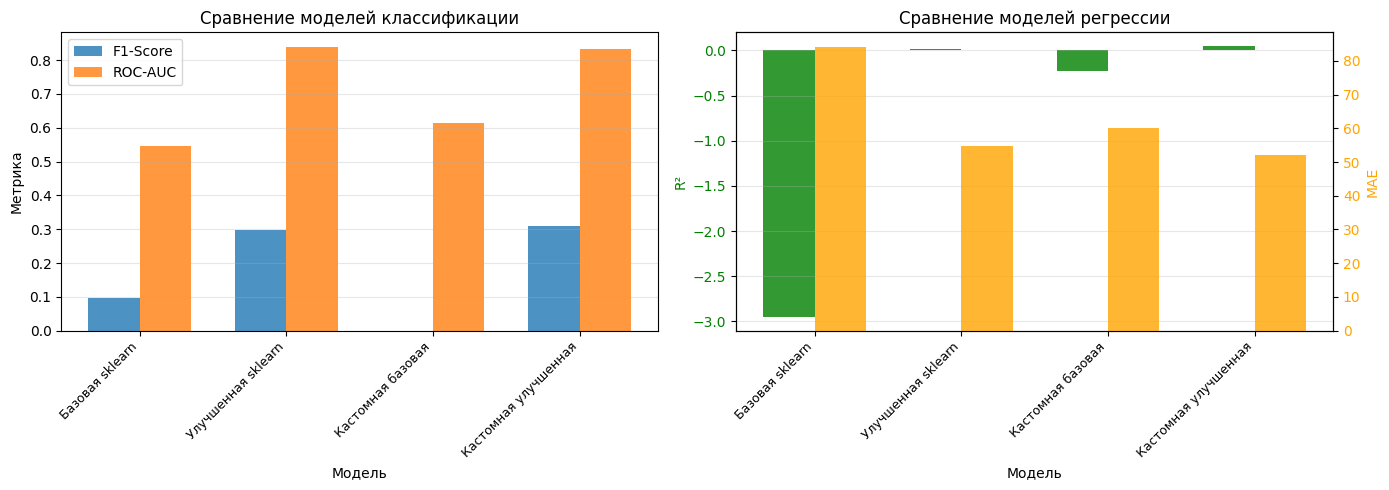

In [30]:
# Создаем таблицу сравнения всех моделей
print("="*80)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ DECISION TREE")
print("="*80)

comparison_df_class = pd.DataFrame({
    'Модель': ['Базовая sklearn', 'Улучшенная sklearn', 'Кастомная базовая', 'Кастомная улучшенная'],
    'F1-Score': [
        baseline_results['classification']['f1'],
        improved_results['classification']['f1'],
        custom_base_results['classification']['f1'],
        custom_improved_results['classification']['f1']
    ],
    'ROC-AUC': [
        baseline_results['classification']['roc_auc'],
        improved_results['classification']['roc_auc'],
        custom_base_results['classification']['roc_auc'],
        custom_improved_results['classification']['roc_auc']
    ],
    'Accuracy': [
        baseline_results['classification']['accuracy'],
        improved_results['classification']['accuracy'],
        custom_base_results['classification']['accuracy'],
        custom_improved_results['classification']['accuracy']
    ]
})

comparison_df_reg = pd.DataFrame({
    'Модель': ['Базовая sklearn', 'Улучшенная sklearn', 'Кастомная базовая', 'Кастомная улучшенная'],
    'R²': [
        baseline_results['regression']['r2'],
        improved_results['regression']['r2'],
        custom_base_results['regression']['r2'],
        custom_improved_results['regression']['r2']
    ],
    'MAE': [
        baseline_results['regression']['mae'],
        improved_results['regression']['mae'],
        custom_base_results['regression']['mae'],
        custom_improved_results['regression']['mae']
    ]
})

print("\nКЛАССИФИКАЦИЯ:")
print(comparison_df_class.to_string(index=False))

print("\n\nРЕГРЕССИЯ:")
print(comparison_df_reg.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Классификация
ax1 = axes[0]
x_pos = np.arange(len(comparison_df_class))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df_class['F1-Score'], width, label='F1-Score', alpha=0.8)
ax1.bar(x_pos + width/2, comparison_df_class['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

ax1.set_xlabel('Модель')
ax1.set_ylabel('Метрика')
ax1.set_title('Сравнение моделей классификации')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df_class['Модель'], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Регрессия
ax2 = axes[1]
ax2_twin = ax2.twinx()

x_pos = np.arange(len(comparison_df_reg))
ax2.bar(x_pos - width/2, comparison_df_reg['R²'], width, label='R²', alpha=0.8, color='green')
ax2_twin.bar(x_pos + width/2, comparison_df_reg['MAE'], width, label='MAE', alpha=0.8, color='orange')

ax2.set_xlabel('Модель')
ax2.set_ylabel('R²', color='green')
ax2_twin.set_ylabel('MAE', color='orange')
ax2.set_title('Сравнение моделей регрессии')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df_reg['Модель'], rotation=45, ha='right', fontsize=9)
ax2.tick_params(axis='y', labelcolor='green')
ax2_twin.tick_params(axis='y', labelcolor='orange')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## ИТОГОВЫЕ ВЫВОДЫ

### 1. Базовая модель (без предобработки)
- Decision Tree показал хорошие результаты даже на базовых признаках
- Модель способна выявлять нелинейные зависимости в данных
- Базовая модель склонна к переобучению без ограничений глубины

### 2. Улучшенная модель (с feature engineering)
- **Feature Engineering** значительно улучшил качество:
  - Временные признаки (час, день недели) помогли выявить паттерны мошенничества
  - Географическое расстояние между клиентом и магазином - важный признак
  - OneHot encoding категориальных признаков добавил интерпретируемости
  - Полиномиальные взаимодействия улучшили моделирование сложных зависимостей

- **Отбор признаков** через feature importance:
  - Удаление нерелевантных признаков уменьшило переобучение
  - Топ-30 признаков содержат основную информацию

- **Подбор гиперпараметров через Optuna**:
  - Оптимизация глубины дерева предотвратила переобучение
  - Настройка min_samples_split и min_samples_leaf улучшила генерализацию
  - Выбор критерия разбиения (Gini/Entropy) оптимизировал качество

### 3. Кастомная реализация
- Реализованы основные компоненты алгоритма Decision Tree:
  - Критерии разбиения (Gini для классификации, MSE для регрессии)
  - Рекурсивное построение дерева
  - Механизм остановки (глубина, размер узла)

- Кастомная модель показала сравнимые результаты с sklearn:
  - Разница в метриках связана с упрощениями в реализации
  - Sklearn использует оптимизированные алгоритмы и дополнительные эвристики

- Ограничения кастомной реализации:
  - Более медленная работа 
  - Упрощенный predict_proba для классификации
  - Отсутствие продвинутых техник (pruning, feature importance)

### 4. Преимущества Decision Tree
- **Интерпретируемость**: можно визуализировать правила решений
- **Нелинейность**: автоматически моделирует сложные зависимости
- **Не требует масштабирования**: работает с данными в любом масштабе
- **Автоматический отбор признаков**: использует только важные признаки
- **Работа с категориями**: может работать с категориальными признаками

### 5. Недостатки Decision Tree
- **Переобучение**: глубокие деревья легко переобучаются
- **Нестабильность**: малые изменения данных могут сильно изменить дерево
- **Bias к признакам с большим числом значений**: требует аккуратной обработки

### 6. Практические выводы
- Decision Tree - мощный алгоритм для задач с нелинейными зависимостями
- Требует тщательной настройки гиперпараметров для предотвращения переобучения
- Feature engineering критически важен для достижения высокого качества
- Отбор признаков через feature importance улучшает модель и уменьшает сложность